## Change Score Models (CSMs)

### 1. Introduction
In this section of the tutorial we will work with the data frame `depression`. This data frame contains the same information as `dep_long` but in wide format. This is a requirement for *semopy* because the names of variables included in the model definition must be the same as in the data frame. 

Change Score Models (CSMs) are a family of SEMs that are used to investigate change. As you learned during the theoretical part of this seminar, the core of these models is to model change as a phantom latent variable. The next code chunk specifies a change score model using `semopy` syntax:

In [ ]:
#######################################################
## Specify R environment for rpy2
import os
os.environ['R_HOME'] = r'C:/Program Files/R/R-4.4.3'  # Replace with your R path
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr
from rpy2.robjects import Formula
import contextlib
# Ipython extension for plotting
%load_ext rpy2.ipython
########################################################

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image, display


depression = pd.read_csv("../MLM_and_CSM/Datasets/depression.csv")
depression.head()


The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


,id,group,pre,post,EM,change
0,1,0,34,76,25,42
1,2,0,87,51,34,-36
2,3,0,68,71,15,3
3,4,0,38,72,41,34
4,5,0,82,47,14,-35


### 2. Modeling
Note that following the explanation provided during the theoretical part of this seminar, the post-treatment measure (post) is decomposed into the phantom variable representing the change (ph_change) and the pre-treatment measure (pre). In addition, a covariance between "pre" and "ph_change" can be specified in order to assess whether depression values at the "pre-intervention" time point are associated with the change. This is an additional parameter that cannot be estimated in the MLM framework. It thus illustrates that change scores SEMs are more flexible than MLMs for the modeling of change.  

For the modeling, we will use Rpy2 library that enables us to run R code within python environment. The next code chunck fit the model (create a model object) by using `sem()` from the `lavaan` package and request a summary of the estimated parameters (`summary()`) and plot the model (`semPlot()`). Hint: We are interested in investigating the mean estimates of pre-depression and change, so `sem()` should include the argument: "meanstructure = TRUE". If this is not specified, only the variance of the pre-therapy depression scores and individual differences in change (variance of the change) will be estimated, but not the average change.

lavaan 0.6-19 ended normally after 47 iterations

  Estimator                                         ML
  Optimization method                           NLMINB
  Number of model parameters                         5

  Number of observations                           100

Model Test User Model:
                                                      
  Test statistic                                 0.000
  Degrees of freedom                                 0

Model Test Baseline Model:

  Test statistic                                 0.193
  Degrees of freedom                                 1
  P-value                                        0.660

User Model versus Baseline Model:

  Comparative Fit Index (CFI)                    1.000
  Tucker-Lewis Index (TLI)                       1.000

Loglikelihood and Information Criteria:

  Loglikelihood user model (H0)               -862.911
  Loglikelihood unrestricted model (H1)       -862.911
                                                

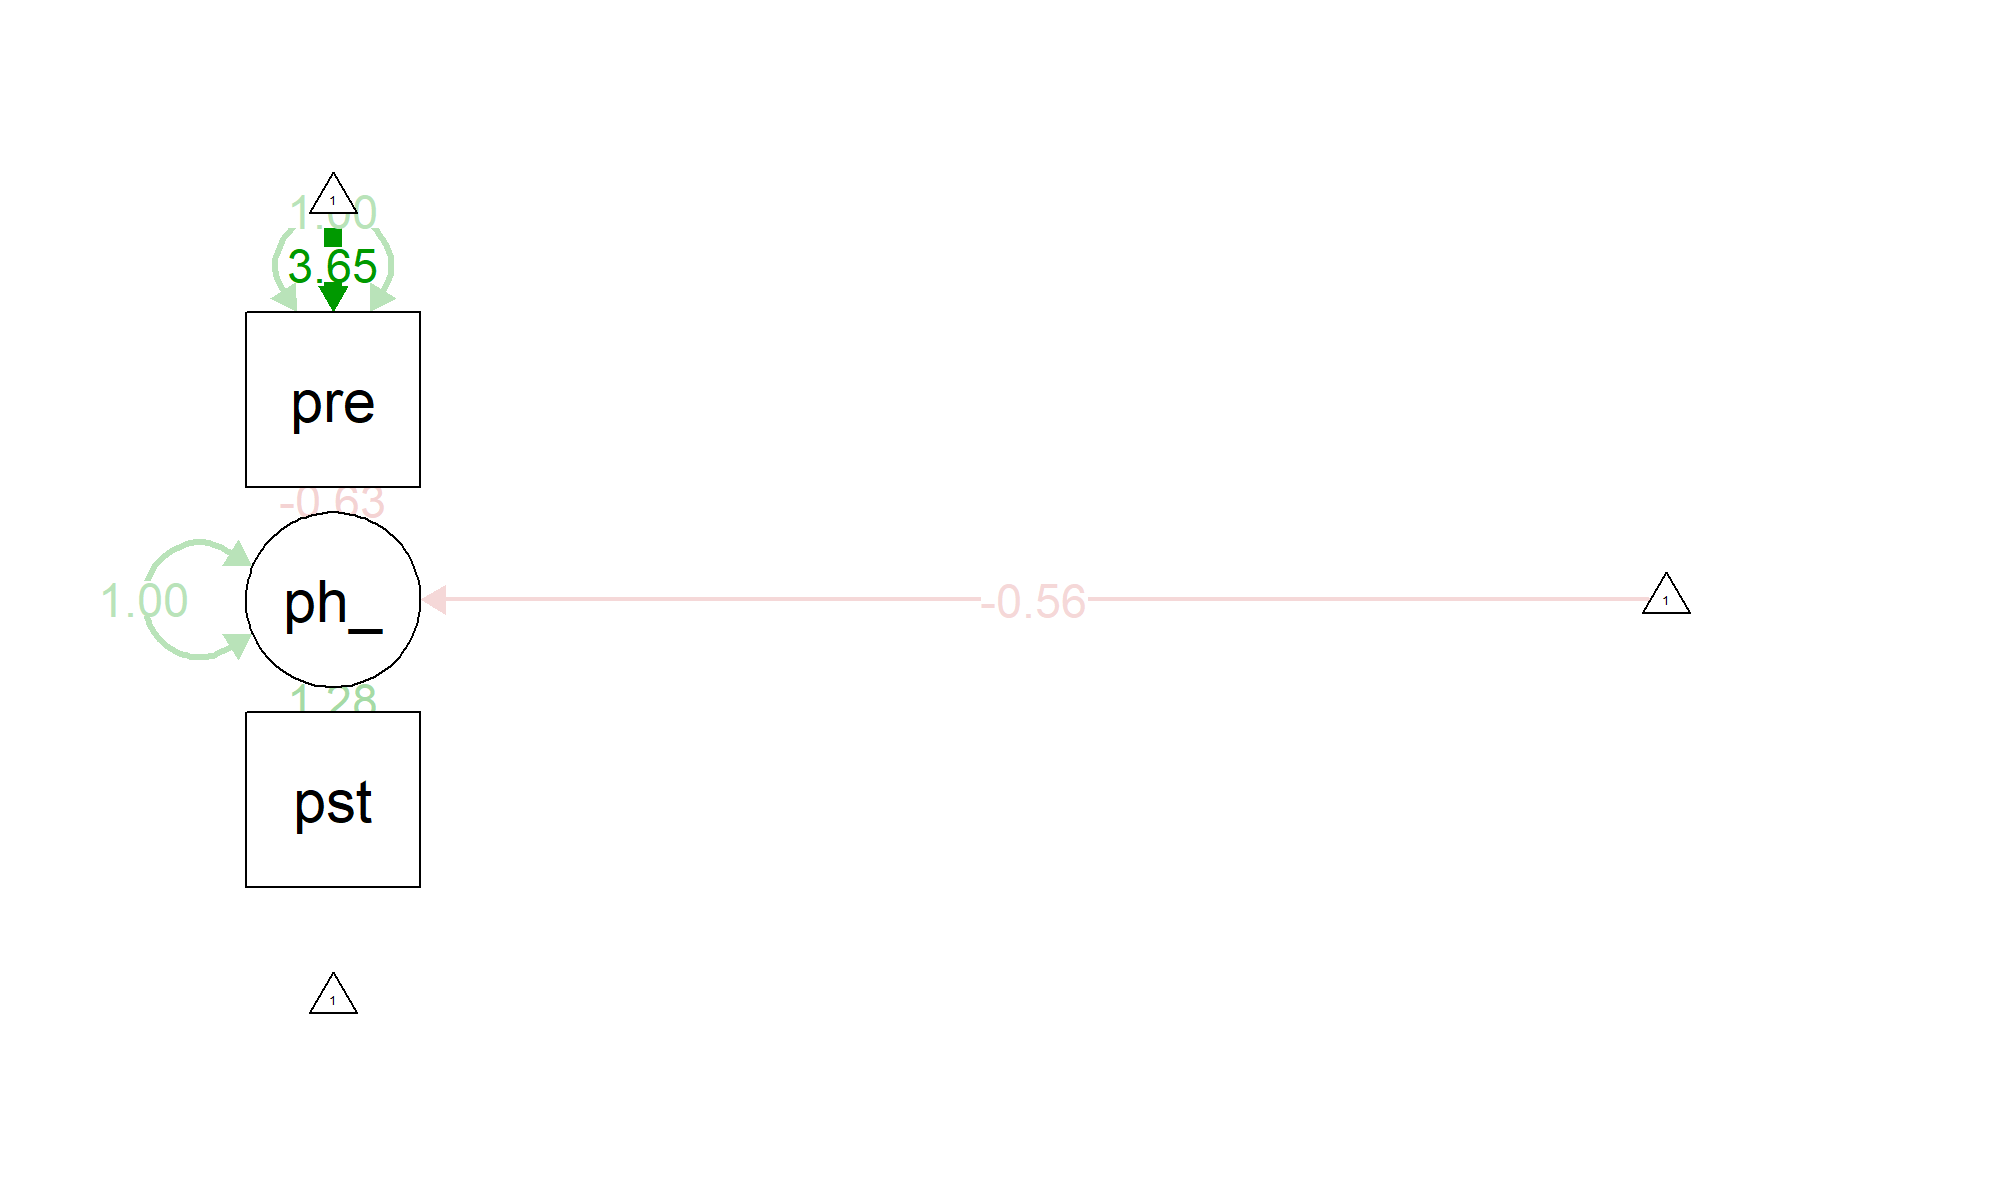

In [4]:
# Activate pandas2ri for automatic conversion
pandas2ri.activate()

# Import the lavaan package in R
ro.r('library(lavaan)')

# Import semPlot for plotting SEM paths
ro.r('library(semPlot)')

# Load the dataset into R
ro.globalenv['depression'] = pandas2ri.py2rpy(depression)

# Define the SEM model
ro.r('''
m1 <- '
# Fixing change score loading to 1
ph_change =~ 1*post

# Fixing baseline loading to 1
post ~ 1*pre

# Fixing post-treatment score residual variance to 0
post ~~ 0*post

# Fixing post-treatment score intercept to 0
post ~ 0 * 1 

# Freely estimate phantom variable and baseline means. The default would fix them to 0
ph_change ~ 1 
pre ~ 1

# Include covariance between phantom change variable and baseline
ph_change ~~ pre
'
''')

# Fit the SEM model
ro.r('fit1 <- sem(m1, data=depression, meanstructure=TRUE)')

# Display the summary of the SEM model
summary = ro.r('summary(fit1, fit.measures=TRUE, standardized=TRUE)')
print(summary)

# Save the SEM path diagram as a PNG file
ro.r('''
png("../MLM_and_CSM/Datasets/semPath1.png", width = 2000, height = 1200, res = 150)
semPaths(fit1, what="std", layout="tree", edge.label.cex=1.2, sizeMan=10, sizeLat=10)
dev.off()
''')

# Display the saved SEM path diagram in Jupyter Notebook
from IPython.display import Image, display
display(Image(filename="../MLM_and_CSM/Datasets/semPath1.png"))

### 3. Interpretation

What can we learn from this output?

* A good practice is to first confirm that the fixed parameters have the values that we specified: Perfect regression (fixed to 1) of the post-depression variable onto the pre-depression variable and the phantom variable change (ph_change).
* Covariances: There is a negative covariance between the pre-therapy depression score and "ph_change". This means that the change between pre- and post-assessment was larger for those individuals who started with lower scores at pre-intervention. 
* Means: The "intercept" estimates indicate the means corresponding to the different variables in the model. For example, the mean change was **-14.190** and the mean pre-therapy depression score was **60.830**. Do these numbers look familiar to you? Go back to multilevel model "mu" and have a look at the fixed effects. Then you should be able to interpret the values.  

* The variance estimates will tell you how much individuals differ with respect to their starting values and their change over time. Both of these variances are significant in our example, meaning that, statistically speaking, there are substantial individual differences in the way people changed over time and with respect to their starting depression values too. 